In [ ]:

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from medmnist import ChestMNIST
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# !pip install medmnist

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else: device = "cpu"
device

'cuda'

In [ ]:
transformer = transforms.Compose([transforms.ToTensor(),
                         transforms.Normalize((0.5,), (0.5,))])
train_data = ChestMNIST(split = "train", transform=transformer, download=True)
test_data = ChestMNIST(split = "test", transform= transformer, download=True)
val_data = ChestMNIST(split="val", transform=transformer, download=True)

100%|██████████| 82.8M/82.8M [00:04<00:00, 18.3MB/s]


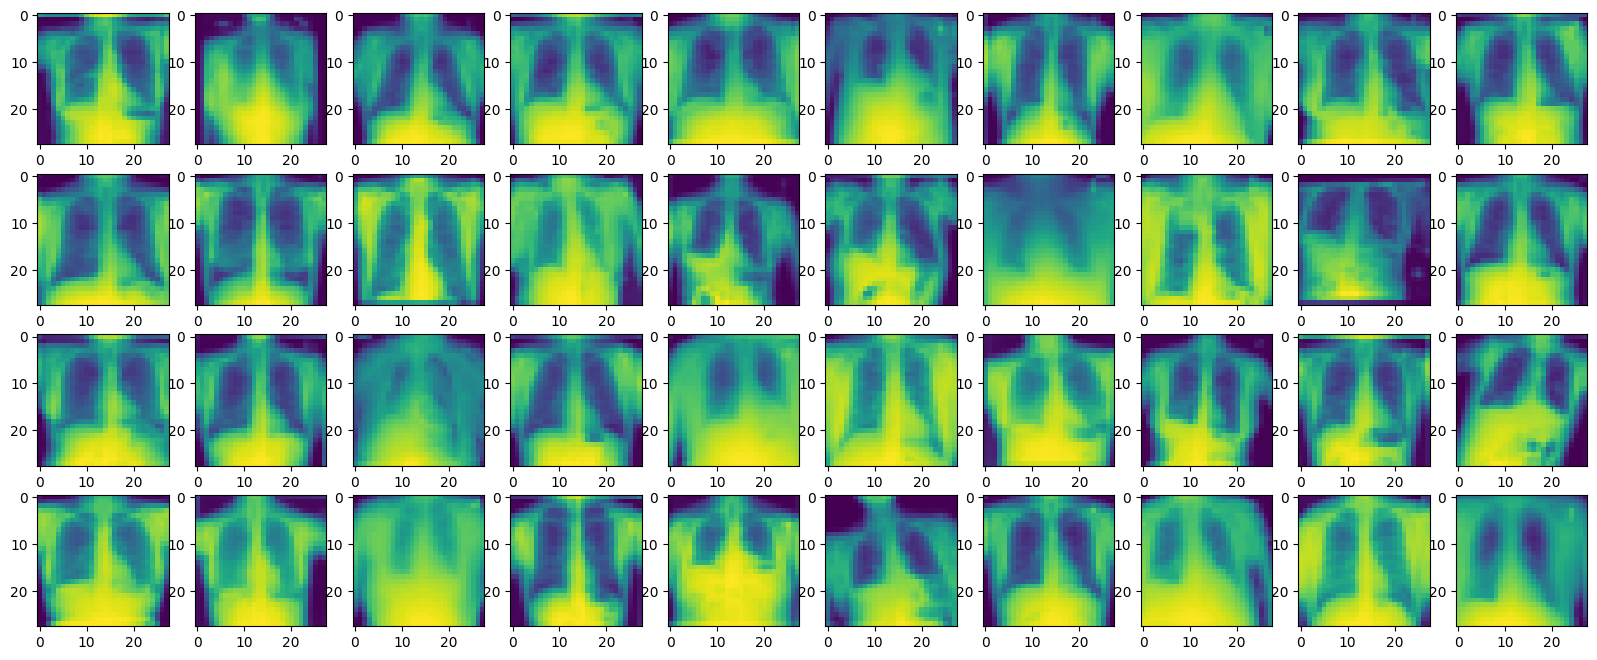

In [ ]:
train_loader = DataLoader(train_data, batch_size=128, shuffle = True)
test_loader = DataLoader(test_data, batch_size=128, shuffle = True)
val_loader = DataLoader(val_data, batch_size=128, shuffle = True)
for x, y in train_loader:
  plt.figure(figsize=(20, 8))
  for i in range(40):
    plt.subplot(4, 10 ,i+1)
    plt.imshow(x[i].squeeze())
  break

In [ ]:
class MyNN(nn.Module):
  def __init__(self, input_size, num_classes):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
  def forward(self, x):
   return self.seq(x)

In [ ]:

class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
list_of_loss_train = []
list_of_loss_val = []
model = MyNN(input_size=28*28, num_classes=14).to(device)
loss_func = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(params = model.parameters(), lr=1e-5)
for epoch in range(30):
  for train, val in zip(train_loader, val_loader):
    x_train = train[0].to(device)
    y_train = train[1].to(device)
    x_val = val[0].to(device)
    y_val = val[1].to(device)
    model.train()
    y_pred_train = model(x_train)
    loss_train = loss_func(y_pred_train, y_train.float())
    opt.zero_grad()
    loss_train.backward()
    opt.step()
    list_of_loss_train.append(loss_train.detach().cpu())
    model.eval()
    with torch.inference_mode():
      y_pred_val = model(x_val)
      loss_val = loss_func(y_pred_val, y_val.float())
      list_of_loss_val.append(loss_val.cpu())

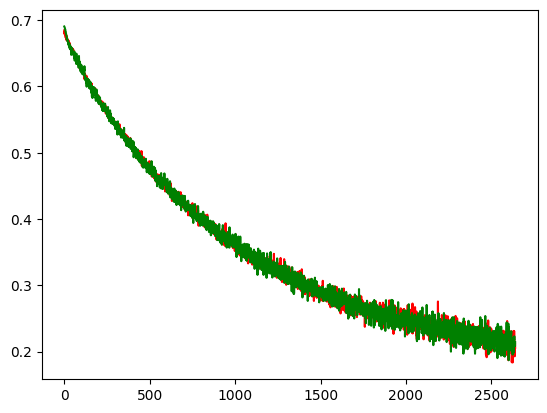

In [ ]:
plt.plot(range(len(list_of_loss_train)), list_of_loss_train, c="r")
plt.plot(range(len(list_of_loss_val)), list_of_loss_val, c = "g")

In [ ]:
from sklearn.metrics